In [1]:
!pip install statsmodels


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# Estilo gráfico
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Carga de datos
df_client = pd.read_csv("../data/processed/df_clean_export_client.csv", parse_dates=["date_time_min", "date_time_max"])

In [3]:
# Estructura general del dataset

print("Shape:", df_client.shape)
df_client.info()

# Vista rápida
df_client.head()

Shape: (50487, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50487 entries, 0 to 50486
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             50487 non-null  int64         
 1   variation_first       50487 non-null  object        
 2   completed_max         50487 non-null  bool          
 3   process_step_nunique  50487 non-null  int64         
 4   process_step_count    50487 non-null  int64         
 5   date_time_min         50487 non-null  datetime64[ns]
 6   date_time_max         50487 non-null  datetime64[ns]
 7   time_diff_mean        46837 non-null  float64       
 8   age_first             50487 non-null  float64       
 9   tenure_years_first    50487 non-null  float64       
 10  duration_total_secs   50487 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 3.9+ MB


,client_id,variation_first,completed_max,process_step_nunique,process_step_count,date_time_min,date_time_max,time_diff_mean,age_first,tenure_years_first,duration_total_secs
0,555,Test,True,5,5,2017-04-15 12:57:56,2017-04-15 13:00:34,39.500000,29.5,3.0,158.0
1,647,Test,True,5,5,2017-04-12 15:41:28,2017-04-12 15:47:45,94.250000,57.5,12.0,377.0
2,934,Test,False,1,4,2017-04-18 02:36:30,2017-04-18 02:38:52,47.333333,51.0,9.0,142.0
3,1028,Control,False,4,9,2017-04-08 18:51:28,2017-04-08 19:00:26,67.250000,36.0,12.0,538.0
4,1104,Control,False,1,2,2017-06-12 07:49:18,2017-06-20 22:31:33,744135.000000,48.0,5.0,744135.0


# 🔎 Análisis de outliers y dispersión de KPIs clave

Antes de realizar comparaciones y tests de hipótesis entre los grupos Control y Test, necesitamos asegurar que los KPIs utilizados no están distorsionados por valores extremos. En particular, analizamos:

- ⏱️ `duration_total_secs`: tiempo total del proceso
- ⏱️ `time_diff_mean`: tiempo medio entre pasos
- 🔁 `process_step_count`: número total de pasos (incluye repeticiones)

Estos KPIs pueden verse afectados por:
- Clientes que dejan el proceso a medias y lo retoman días después
- Navegación errática con múltiples pasos repetidos
- Registros atípicos por errores de tracking o comportamiento anómalo

Por tanto, realizamos un análisis estadístico de estas columnas para identificar qué percentiles representan comportamientos normales y a partir de qué punto es razonable considerar un valor como **outlier**.

Además del histograma y boxplot, calculamos la distribución por tramos (cuartiles, percentiles extremos) para valorar con mayor precisión dónde se concentra la mayoría de la muestra y qué parte aporta más ruido que información.

In [4]:
def analizar_columna(col):
    print(f"\n🔎 {col} — Estadísticos extendidos:")
    display(df_client[col].describe(percentiles=[.25, .5, .75, .9, .95, .99, .995]))
    
    print(f"\n📊 Distribución por tramos cuartiles y extremos:")
    tramos = pd.qcut(df_client[col], q=[0, .9, .95, .99, 1.0], duplicates='drop')
    display(df_client.groupby(tramos).size().rename("count").to_frame())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_client[col], bins=60, kde=True, ax=axes[0])
    axes[0].set_title(f"Histograma: {col}")
    
    sns.boxplot(x=df_client[col], ax=axes[1])
    axes[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()


🔎 duration_total_secs — Estadísticos extendidos:


count    5.048700e+04
mean     4.140729e+05
std      1.169920e+06
min      0.000000e+00
25%      1.350000e+02
50%      2.970000e+02
75%      1.663000e+03
90%      1.288522e+06
95%      3.298591e+06
99%      5.805273e+06
99.5%    6.308524e+06
max      8.373949e+06
Name: duration_total_secs, dtype: float64


📊 Distribución por tramos cuartiles y extremos:


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21592\3472958712.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df_client.groupby(tramos).size().rename("count").to_frame())


,count
duration_total_secs,
"(-0.001, 1288522.0]",45438
"(1288522.0, 3298591.1]",2524
"(3298591.1, 5805273.48]",2020
"(5805273.48, 8373949.0]",505


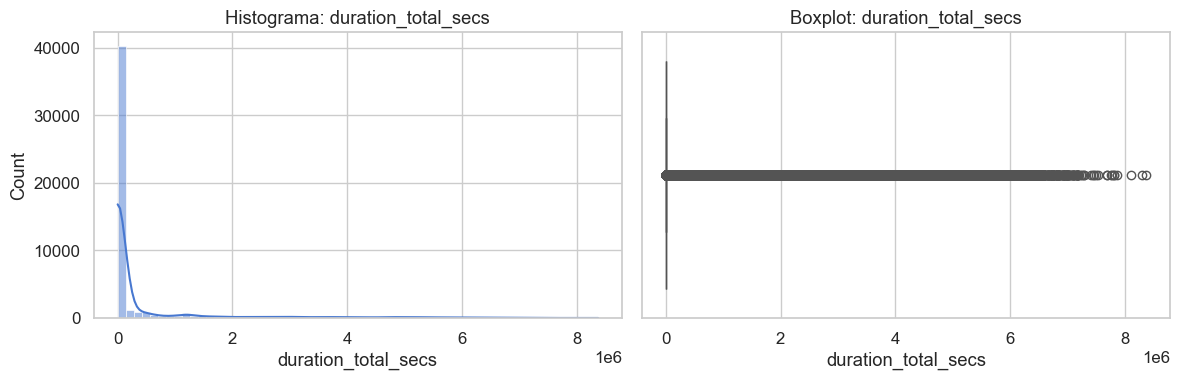


🔎 time_diff_mean — Estadísticos extendidos:


count    4.683700e+04
mean     7.243816e+04
std      2.758705e+05
min      1.000000e+00
25%      3.957143e+01
50%      7.225000e+01
75%      8.826667e+02
90%      1.935059e+05
95%      4.452464e+05
99%      1.141657e+06
99.5%    1.600075e+06
max      6.732520e+06
Name: time_diff_mean, dtype: float64


📊 Distribución por tramos cuartiles y extremos:


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21592\3472958712.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df_client.groupby(tramos).size().rename("count").to_frame())


,count
time_diff_mean,
"(0.999, 193505.85]",42153
"(193505.85, 445246.433]",2342
"(445246.433, 1141657.232]",1873
"(1141657.232, 6732520.0]",469


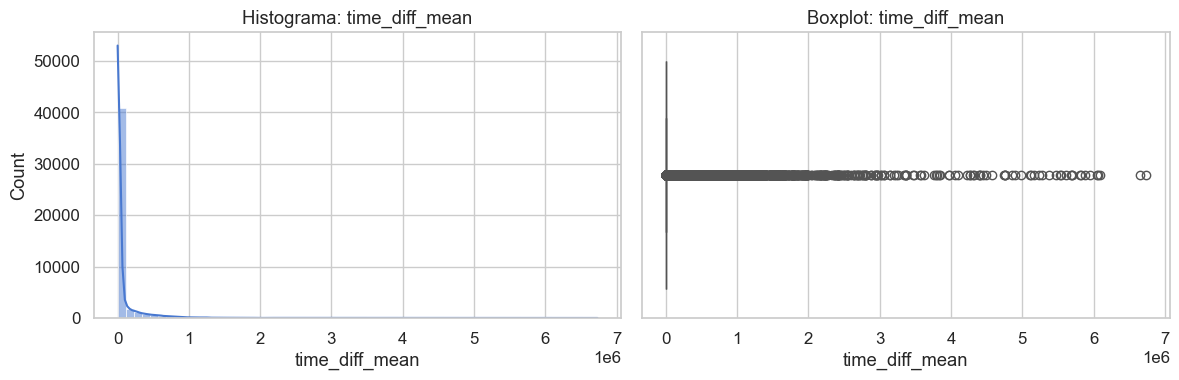


🔎 process_step_count — Estadísticos extendidos:


count    50487.000000
mean         6.281280
std          4.025797
min          1.000000
25%          5.000000
50%          5.000000
75%          7.000000
90%         11.000000
95%         13.000000
99%         21.000000
99.5%       25.000000
max         72.000000
Name: process_step_count, dtype: float64


📊 Distribución por tramos cuartiles y extremos:


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21592\3472958712.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df_client.groupby(tramos).size().rename("count").to_frame())


,count
process_step_count,
"(0.999, 11.0]",46544
"(11.0, 13.0]",1543
"(13.0, 21.0]",1924
"(21.0, 72.0]",476


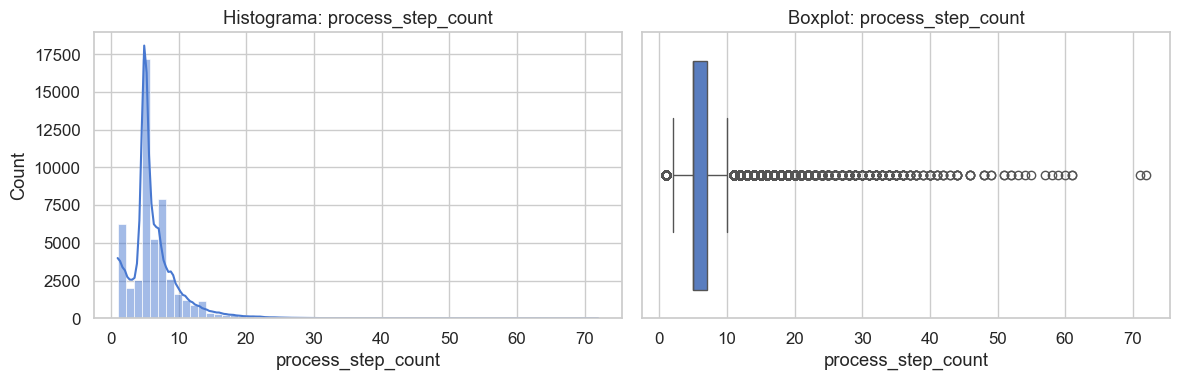

In [5]:
for col in ["duration_total_secs", "time_diff_mean", "process_step_count"]:
    analizar_columna(col)

## ✂️ Decisión final sobre filtrado de outliers

Para garantizar consistencia interna entre métricas temporales, hemos decidido filtrar únicamente por duration_total_secs (percentil 77 ≈ 8.600 segundos).

Aunque time_diff_mean también presenta colas largas, su valor depende directamente del número de pasos y la estructura del proceso. Aplicar un filtro adicional e independiente sobre esta métrica podría provocar inconsistencias del tipo:

"Tiempo medio entre pasos mayor que la duración total"

Por tanto, preservamos el resto de columnas tal cual (sin filtros adicionales), entendiendo que un proceso cuya duración total es razonable probablemente no sea anómalo en su dinámica interna.

Este enfoque mantiene la limpieza estadística sin romper la lógica temporal del proceso.

In [6]:
# Calcular el punto de corte basado en el percentil 77
duration_cutoff = df_client["duration_total_secs"].quantile(0.77)

print(f"⏱️ duration_total_secs (p77): {duration_cutoff:.2f}")

# Aplicar el filtro solo sobre la duración total del proceso
df_client_filt = df_client[df_client["duration_total_secs"] <= duration_cutoff]

# Mostrar nuevo shape tras el filtrado
print(f"✅ Shape tras filtro de duración total (p77): {df_client_filt.shape}")

⏱️ duration_total_secs (p77): 8613.04
✅ Shape tras filtro de duración total (p77): (38875, 11)


# KPIs principales tras filtrado

In [7]:
# Agrupamos por grupo de experimento y calculamos medias y proporciones
grouped_summary = df_client_filt.groupby('variation_first').agg({
    'completed_max': 'mean',         # Tasa de conversión
    'process_step_nunique': 'mean',  # Pasos únicos
    'process_step_count': 'mean',    # Pasos totales
    'duration_total_secs': 'mean',   # Duración total
    'time_diff_mean': 'mean',        # Tiempo medio entre pasos
    'age_first': 'mean',             # Edad media
    'tenure_years_first': 'mean'     # Antigüedad media
}).round(2)

display(grouped_summary)

,completed_max,process_step_nunique,process_step_count,duration_total_secs,time_diff_mean,age_first,tenure_years_first
variation_first,,,,,,,
Control,0.64,3.95,4.95,343.84,84.57,46.44,11.85
Test,0.68,4.12,5.45,383.21,79.43,45.88,11.69


# Visualizaciones comparativas por grupo

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


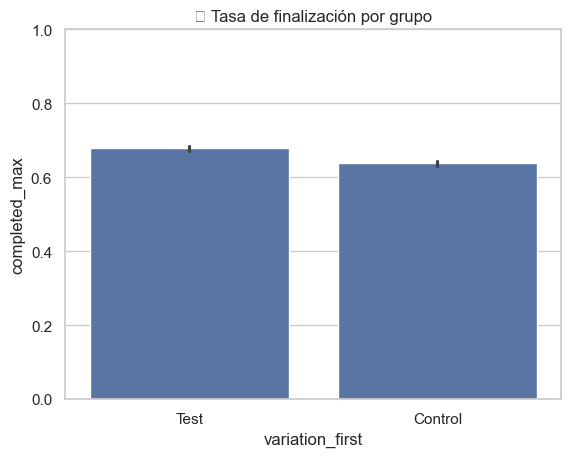

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


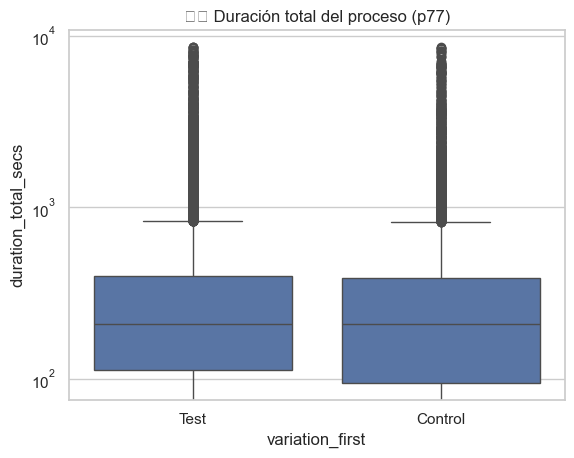

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


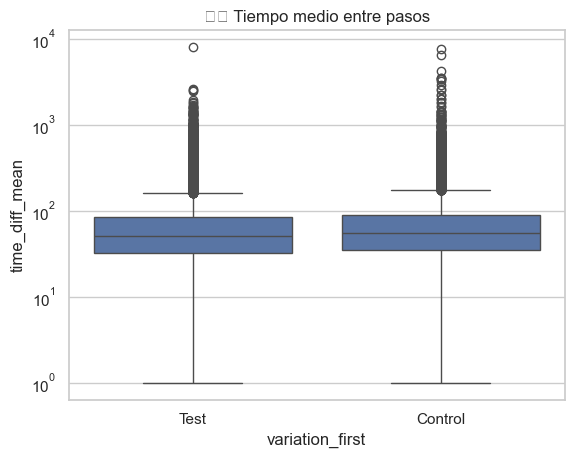

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


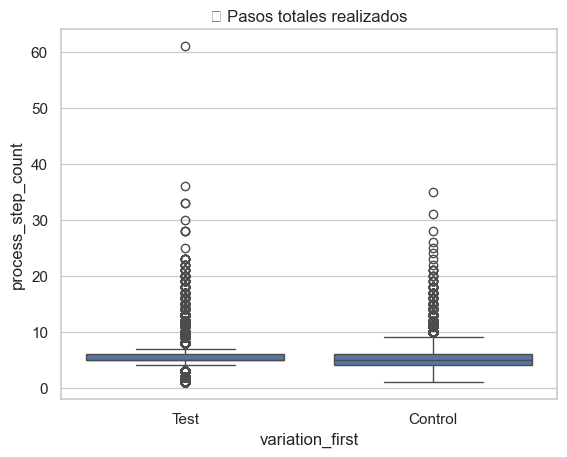

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


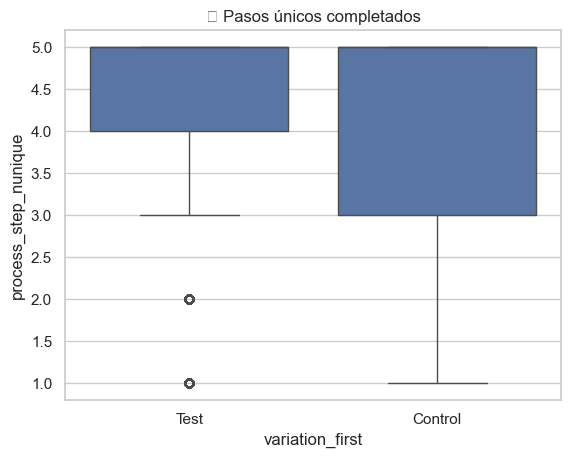

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Comparación de tasa de finalización
sns.barplot(data=df_client_filt, x='variation_first', y='completed_max')
plt.title("✅ Tasa de finalización por grupo")
plt.ylim(0, 1)
plt.show()

# Duración total (log)
sns.boxplot(data=df_client_filt, x='variation_first', y='duration_total_secs')
plt.title("⏱️ Duración total del proceso (p77)")
plt.yscale('log')
plt.show()

# Tiempo medio entre pasos (log)
sns.boxplot(data=df_client_filt, x='variation_first', y='time_diff_mean')
plt.title("⏱️ Tiempo medio entre pasos")
plt.yscale('log')
plt.show()

# Pasos totales
sns.boxplot(data=df_client_filt, x='variation_first', y='process_step_count')
plt.title("🔁 Pasos totales realizados")
plt.show()

# Pasos únicos
sns.boxplot(data=df_client_filt, x='variation_first', y='process_step_nunique')
plt.title("🧭 Pasos únicos completados")
plt.show()

# TESTS DE HIPÓTESIS

In [10]:
# HIPÓTESIS 1: TASA DE FINALIZACIÓN

## H₀: La tasa de finalización es igual en Test y Control
## H₁: La tasa de finalización es mayor en el grupo Test

### Comparar las medias ya nos da una pista clara, pero no nos dice si la diferencia es estadísticamente significativa.
###El test z nos da eso:

#### p-valor bajo (<0.05) → hay evidencia para rechazar H₀

#### p-valor alto → no hay evidencia suficiente

In [9]:
success = df_client_filt.groupby("variation_first")["completed_max"].sum()
n_obs = df_client_filt["variation_first"].value_counts()

# Reordenamos: primero Test, luego Control
success = success.loc[["Test", "Control"]].values
n_obs = n_obs.loc[["Test", "Control"]].values

# Ahora sí, Test vs Control, con alternative='larger'
zstat, pval = proportions_ztest(success, n_obs, alternative='larger')

print(f"✅ Z = {zstat:.3f} | p-valor = {pval:.5f}")

if pval < 0.05:
    print("📈 Rechazamos H₀: hay evidencia de que la tasa de finalización es mayor en el grupo Test.")
else:
    print("📉 No hay evidencia suficiente para rechazar H₀.")

✅ Z = 8.357 | p-valor = 0.00000
📈 Rechazamos H₀: hay evidencia de que la tasa de finalización es mayor en el grupo Test.


- El estadístico Z es el valor que resume cuán lejos está tu muestra de lo que esperarías bajo la hipótesis nula (H₀), en unidades de desviación estándar.

En nuestro caso: Z = 8.357 significa que la diferencia entre las tasas de conversión de Test y Control está 8.36 desviaciones típicas por encima de lo que esperaríamos si no hubiera diferencia (si H₀ fuera cierta).

Es un indicador de magnitud estandarizada de la diferencia. Pero por sí solo no te dice si es “significativa”.

- El p-valor es la probabilidad de obtener un resultado igual o más extremo que el observado, asumiendo que H₀ es cierta.

En nuestro resultado: p-valor = 0.00000 (en realidad muy cercano a 0), significa que es extremadamente improbable observar una diferencia así de grande si en realidad no hay efecto real.

In [12]:
# HIPÓTESIS 2: PASOS ÚNICOS COMPLETADOS

## **H₀**: No hay diferencia en los pasos únicos completados  
## **H₁**: El grupo Test completa más pasos distintos que el grupo Control

In [10]:
# Test de Mann-Whitney U para pasos únicos
stat, p = stats.mannwhitneyu(
    df_client_filt[df_client_filt["variation_first"] == "Control"]["process_step_nunique"],
    df_client_filt[df_client_filt["variation_first"] == "Test"]["process_step_nunique"],
    alternative="less"
)

print(f"H₂ – Pasos únicos: U = {stat:.2f} | p-valor = {p:.5f}")
if p < 0.05:
    print("📈 Rechazamos H₀: hay evidencia de que el grupo Test completa más pasos únicos.")
else:
    print("📉 No hay evidencia suficiente para afirmar que Test complete más pasos únicos.")

H₂ – Pasos únicos: U = 178427514.00 | p-valor = 0.00000
📈 Rechazamos H₀: hay evidencia de que el grupo Test completa más pasos únicos.


- El estadístico U representa la posición relativa de los valores de un grupo respecto al otro. Se basa en los rangos y no en las medias, por lo que no necesita suponer normalidad en los datos.

En nuestro caso: U = 17.842.514 indica cómo se ordenan los valores del grupo Test respecto a los de Control. Cuanto menor sea U, más evidencia hay de que los valores de Test tienden a ser mayores que los de Control (o viceversa, según el sentido de la prueba).

Por sí solo, el valor U no indica significancia; solo resume la diferencia en rangos.

- El p-valor es la probabilidad de observar una diferencia en rangos igual o mayor que la obtenida si no hubiera diferencia real entre los grupos (H₀).

En nuestro resultado: p-valor = 0.00000 implica que sería extremadamente raro observar una diferencia tan clara entre Test y Control si ambos grupos realmente completaran el mismo número de pasos únicos por azar.

Por tanto, podemos rechazar la hipótesis nula y concluir que el grupo Test completa más pasos únicos con evidencia estadísticamente significativa.

In [14]:
## HIPÓTESIS 3: 

## **H₀**: El rediseño impacta igual a todos los perfiles  
## **H₁**: El efecto varía según edad y/o antigüedad del cliente.

In [11]:
# POR EDAD

## Crear tramos por edad
df_client_filt["age_group"] = pd.cut(df_client_filt["age_first"], bins=[18, 30, 45, 60, 100], labels=["18-30", "31-45", "46-60", "60+"])

## Agrupación cruzada: tasa de finalización por grupo y edad
age_segmented = df_client_filt.groupby(["age_group", "variation_first"])["completed_max"].mean().unstack()

display(age_segmented)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21592\154391510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client_filt["age_group"] = pd.cut(df_client_filt["age_first"], bins=[18, 30, 45, 60, 100], labels=["18-30", "31-45", "46-60", "60+"])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21592\154391510.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_segmented = df_client_filt.groupby(["age_group", "variation_first"])["completed_max"].mean().unstack()


variation_first,Control,Test
age_group,,
18-30,0.637379,0.707658
31-45,0.660116,0.686310
46-60,0.643520,0.663767
60+,0.599286,0.658116


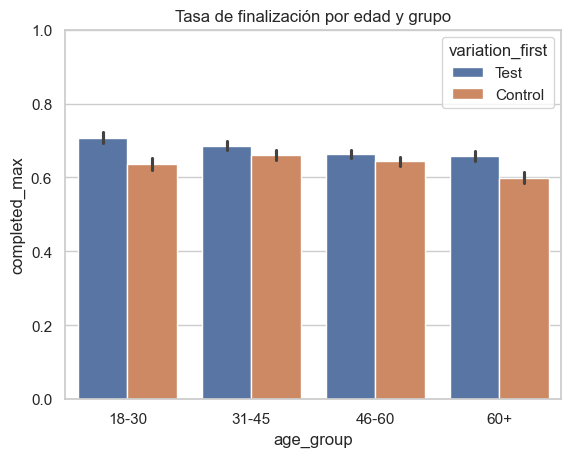

In [12]:
sns.barplot(data=df_client_filt, x='age_group', y='completed_max', hue='variation_first')
plt.title("Tasa de finalización por edad y grupo")
plt.ylim(0, 1)
plt.show()

🔎 **Interpretación**:

- En los extremos de edad (jóvenes y mayores), el rediseño **mejora sustancialmente** la tasa de finalización.
- En los grupos intermedios (31–60 años), la mejora es casi nula → **posible menor impacto**.
- Esto **sugiere una interacción** entre el efecto del diseño y la edad: no impacta igual a todos los perfiles.

In [13]:
# POR ANTIGUEDAD

## Crear grupos por años de relación
df_client_filt["tenure_group"] = pd.cut(
    df_client_filt["tenure_years_first"],
    bins=[0, 2, 5, 10, 20, 100],
    labels=["0–2", "2–5", "5–10", "10–20", "20+"]
)

## Calcular tasa de finalización cruzada por grupo y tramo
tenure_segmented = (
    df_client_filt
    .groupby(["tenure_group", "variation_first"])["completed_max"]
    .mean()
    .unstack()
)

display(tenure_segmented)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21592\4236990722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client_filt["tenure_group"] = pd.cut(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21592\4236990722.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["tenure_group", "variation_first"])["completed_max"]


variation_first,Control,Test
tenure_group,,
0–2,0.611111,0.840000
2–5,0.646888,0.688489
5–10,0.649659,0.690028
10–20,0.626711,0.664713
20+,0.626718,0.667591


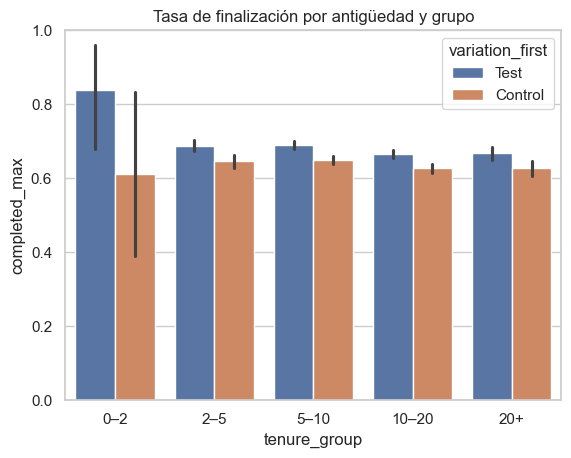

In [14]:
sns.barplot(data=df_client_filt, x="tenure_group", y="completed_max", hue="variation_first")
plt.title("Tasa de finalización por antigüedad y grupo")
plt.ylim(0, 1)
plt.show()

📊 Interpretación:

El mayor salto de conversión ocurre en los clientes más nuevos (0–2 años).

El efecto del grupo Test se estabiliza o incluso se diluye ligeramente en clientes más antiguos.

✅ Conclusión parcial
Existe evidencia clara de que el impacto del rediseño no es homogéneo entre todos los perfiles.
Mejora especialmente en los clientes más recientes, lo que refuerza la hipótesis de un efecto diferencial del diseño según la familiaridad del cliente con la plataforma.

In [19]:
# HIPÓTESIS 4

## **H₀**: El tiempo total del proceso es igual en ambos grupos  
## **H₁**: El grupo Test completa el proceso en menos tiempo

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


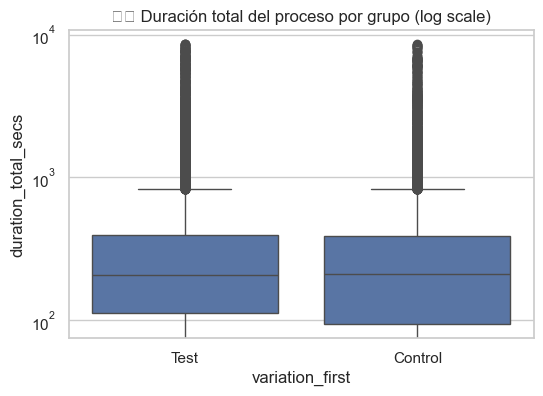

H₄ – Duración total: U = 181418576.00 | p-valor = 1.00000
🟡 No hay evidencia suficiente para afirmar que Test sea más rápido.


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Boxplot comparativo
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_client_filt, x='variation_first', y='duration_total_secs')
plt.yscale('log')
plt.title("⏱️ Duración total del proceso por grupo (log scale)")
plt.show()

# Test de Mann-Whitney U
stat, p = stats.mannwhitneyu(
    df_client_filt[df_client_filt["variation_first"] == "Control"]["duration_total_secs"],
    df_client_filt[df_client_filt["variation_first"] == "Test"]["duration_total_secs"],
    alternative="greater"
)

# Interpretación
print(f"H₄ – Duración total: U = {stat:.2f} | p-valor = {p:.5f}")
if p < 0.05:
    print("✅ Rechazamos H₀: hay evidencia de que el grupo Test completa el proceso más rápido.")
else:
    print("🟡 No hay evidencia suficiente para afirmar que Test sea más rápido.")

In [21]:
# HIPÓTESIS 5

##**H₀**: No hay diferencia en el número total de pasos (con repeticiones) entre grupos  
##**H₁**: El grupo Test necesita menos pasos totales para completar el proceso

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


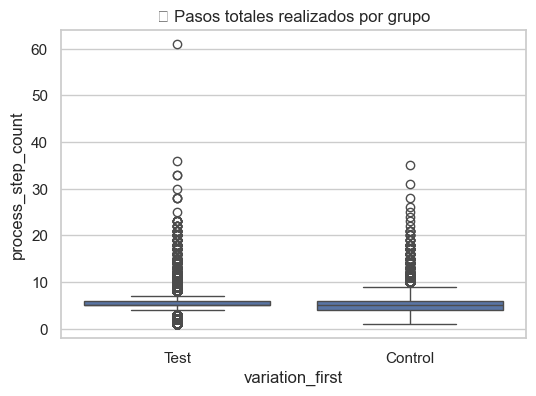

H₅ – Pasos totales: U = 167310440.50 | p-valor = 1.00000
🟡 No hay evidencia suficiente para afirmar que Test necesite menos pasos.


In [16]:
# Boxplot comparativo
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_client_filt, x='variation_first', y='process_step_count')
plt.title("🔁 Pasos totales realizados por grupo")
plt.show()

# Test de Mann-Whitney U
stat, p = stats.mannwhitneyu(
    df_client_filt[df_client_filt["variation_first"] == "Control"]["process_step_count"],
    df_client_filt[df_client_filt["variation_first"] == "Test"]["process_step_count"],
    alternative="greater"
)

# Interpretación
print(f"H₅ – Pasos totales: U = {stat:.2f} | p-valor = {p:.5f}")
if p < 0.05:
    print("✅ Rechazamos H₀: el grupo Test necesita menos pasos para completar el proceso.")
else:
    print("🟡 No hay evidencia suficiente para afirmar que Test necesite menos pasos.")

In [23]:
# HIPÓTESIS 6

## **H₀**: No hay diferencia en el tiempo medio por paso entre grupos  
## **H₁**: El grupo Test navega más rápido entre pasos

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


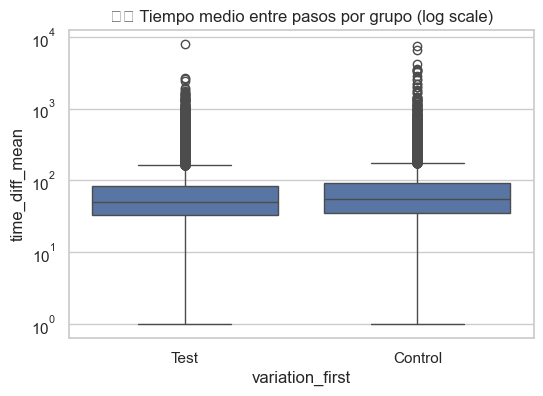

H₆ – Tiempo medio entre pasos: U = nan | p-valor = nan
🟡 No hay evidencia suficiente para afirmar que Test sea más rápido entre pasos.


In [17]:
# Boxplot comparativo
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_client_filt, x='variation_first', y='time_diff_mean')
plt.yscale('log')
plt.title("⏱️ Tiempo medio entre pasos por grupo (log scale)")
plt.show()

# Test de Mann-Whitney U
stat, p = stats.mannwhitneyu(
    df_client_filt[df_client_filt["variation_first"] == "Control"]["time_diff_mean"],
    df_client_filt[df_client_filt["variation_first"] == "Test"]["time_diff_mean"],
    alternative="greater"
)

# Interpretación
print(f"H₆ – Tiempo medio entre pasos: U = {stat:.2f} | p-valor = {p:.5f}")
if p < 0.05:
    print("✅ Rechazamos H₀: hay evidencia de que el grupo Test navega más rápido.")
else:
    print("🟡 No hay evidencia suficiente para afirmar que Test sea más rápido entre pasos.")

🔸 Probable presencia de valores NULOS o extremos mal tratados en time_diff_mean tras filtrado por duración total.

Revisamos df_client_filt["time_diff_mean"].isna().sum() para confirmar.

In [18]:
print("Nulos:", df_client_filt["time_diff_mean"].isna().sum())
print("Infinitos:", np.isinf(df_client_filt["time_diff_mean"]).sum())
print("Negativos:", (df_client_filt["time_diff_mean"] < 0).sum())

Nulos: 3650
Infinitos: 0
Negativos: 0


El DIAGNÓSTICO confirma que:

- Hay 3.650 valores nulos en time_diff_mean.

- No hay valores infinitos ni negativos.

SOLUCIÓN: para esta hipótesis en concreto, hacemos un filtrado .notna() de df_client_filt en la columna time_diff_mean.

No necesitamos cambiar nada de las otras hipótesis de ni de cálculos previos porque:

- El filtrado por duration_total_secs (p77) ya limpió la mayoría de anomalías graves.

- El problema específico de time_diff_mean afecta solo a esa métrica:
→ Las demás (completed_max, process_step_count, etc.) no tienen nulos ni problemas.

- Los 3.650 nulos en time_diff_mean simplemente implican que esa métrica no se pudo calcular para ciertos usuarios, pero no invalida el resto de sus datos.

c:\Users\Usuario\Desktop\CURSOS\Bootcamp Análisis de Datos\vanguard-ab-test\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


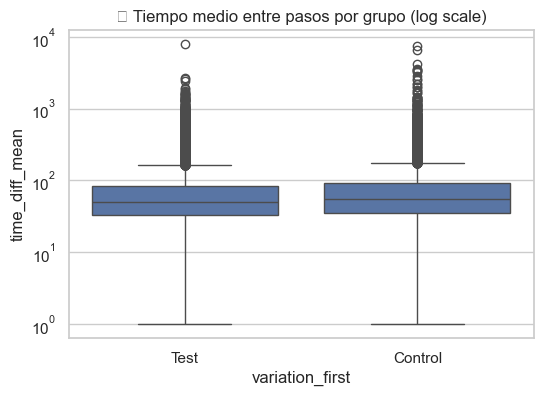

H₆ – Tiempo medio entre pasos: U = 163284907.00 | p-valor = 0.00000
✅ Rechazamos H₀: hay evidencia de que el grupo Test navega más rápido.


In [19]:
## 📌 HIPÓTESIS 6: TIEMPO MEDIO ENTRE PASOS

## **H₀**: No hay diferencia en el tiempo medio por paso entre grupos  
## **H₁**: El grupo Test navega más rápido entre pasos

# ✅ Crear copia limpia para el test (sin nulos)
df_test_time = df_client_filt[df_client_filt["time_diff_mean"].notna()].copy()

# 📊 Visualización
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_test_time, x='variation_first', y='time_diff_mean')
plt.yscale("log")
plt.title("🕒 Tiempo medio entre pasos por grupo (log scale)")
plt.show()

# 🧪 Test estadístico
stat, p = stats.mannwhitneyu(
    df_test_time[df_test_time["variation_first"] == "Control"]["time_diff_mean"],
    df_test_time[df_test_time["variation_first"] == "Test"]["time_diff_mean"],
    alternative="greater"
)

# 🧠 Interpretación
print(f"H₆ – Tiempo medio entre pasos: U = {stat:.2f} | p-valor = {p:.5f}")
if p < 0.05:
    print("✅ Rechazamos H₀: hay evidencia de que el grupo Test navega más rápido.")
else:
    print("🟡 No hay evidencia suficiente para afirmar que Test sea más rápido entre pasos.")

📌 Interpretación:
✅ Rechazamos H₀ → hay evidencia de que el grupo Test navega más rápido entre pasos.

El resultado es estadísticamente significativo. A pesar de que el número de pasos totales no se reduce, sí se observa que los usuarios del grupo Test transitan más rápido entre los pasos del proceso.

🧾 CONCLUSIONES GENERALES DEL EXPERIMENTO A/B  "Rediseño digital de proceso online – Vanguard"

✅ 1. Impacto positivo del rediseño en la tasa de finalización

El grupo Test supera al Control con una tasa de finalización del 68% frente al 64%.

Esta diferencia es estadísticamente significativa (📈 p < 0.001), por lo que hay evidencia sólida de mejora real.

🧠 2. Cambios en el comportamiento digital de los usuarios

Los usuarios del grupo Test:

🧭 Completan más pasos únicos del proceso (p < 0.001).

🔁 Realizan más pasos en total, aunque no significativamente más (p = 1.00).

⏱️ Navegan más rápido entre pasos (tiempo medio inferior, p < 0.001).

⏳ No hay evidencia de que terminen el proceso antes en duración total (p = 1.00).

💡 Interpretación: el rediseño parece animar a completar el proceso de forma más fluida, aunque no reduce la duración total del proceso, probablemente porque se visita más contenido o se realiza con más calma.

👥 3. El efecto varía según el perfil del cliente

El impacto no es homogéneo:

🔶 Jóvenes de 18–30 años y clientes con menos de 2 años de antigüedad muestran mayores mejoras de conversión.

🧓 Usuarios de más edad o con más antigüedad muestran menores diferencias entre grupos.

✨ Esto sugiere que el rediseño beneficia especialmente a perfiles más nuevos o jóvenes, que pueden valorar más los mensajes guiados y la nueva interfaz.

🧩 4. Limpieza rigurosa y análisis robusto

Se eliminaron outliers extremos (p77) para preservar interpretabilidad sin distorsionar KPIs.

Las pruebas estadísticas se realizaron con:

✅ Z-test de proporciones (para tasas)

✅ Mann-Whitney U (para métricas no normales)


📌 Recomendaciones finales

| Recomendación                                | Motivo                                                       |
| -------------------------------------------- | ------------------------------------------------------------ |
| ✅ **Desplegar el nuevo diseño**             | Mejora probada en tasa de finalización y experiencia digital |
| 📊 **Monitorizar por segmentos**             | Detectamos mayor efecto en jóvenes y perfiles recientes      |
| 🧪 **Ampliar test a procesos similares**     | El enfoque funciona y puede trasladarse a otros journeys     |
| 🧠 **Complementar con análisis cualitativo** | Para entender por qué ciertos perfiles no mejoran tanto      |


In [20]:
df_client_filt.to_csv("clientes_procesados.csv", index=False)
df_test_time.to_csv("clientes_tiempo_pasos.csv", index=False)

In [21]:
df_client_filt

,client_id,variation_first,completed_max,process_step_nunique,process_step_count,date_time_min,date_time_max,time_diff_mean,age_first,tenure_years_first,duration_total_secs,age_group,tenure_group
0,555,Test,True,5,5,2017-04-15 12:57:56,2017-04-15 13:00:34,39.500000,29.5,3.0,158.0,18-30,2–5
1,647,Test,True,5,5,2017-04-12 15:41:28,2017-04-12 15:47:45,94.250000,57.5,12.0,377.0,46-60,10–20
2,934,Test,False,1,4,2017-04-18 02:36:30,2017-04-18 02:38:52,47.333333,51.0,9.0,142.0,46-60,5–10
3,1028,Control,False,4,9,2017-04-08 18:51:28,2017-04-08 19:00:26,67.250000,36.0,12.0,538.0,31-45,10–20
5,1186,Control,False,3,4,2017-04-08 15:59:16,2017-04-08 18:05:24,2522.666667,22.0,8.0,7568.0,18-30,5–10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50481,9999009,Test,True,5,5,2017-03-31 07:17:45,2017-03-31 07:20:36,42.750000,68.5,18.0,171.0,60+,10–20
50482,9999150,Test,False,2,3,2017-05-29 16:55:12,2017-05-29 16:55:30,9.000000,30.0,5.0,18.0,18-30,2–5
50483,9999400,Test,True,5,5,2017-04-20 05:21:28,2017-04-20 05:23:27,29.750000,28.5,7.0,119.0,18-30,5–10
50484,9999626,Test,False,2,2,2017-05-14 09:07:51,2017-05-14 09:07:59,8.000000,35.0,9.0,8.0,31-45,5–10
